In [25]:
import os
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [27]:
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")
print("Dataset downloaded to:", path)

Dataset downloaded to: C:\Users\admin\.cache\kagglehub\datasets\omkargurav\face-mask-dataset\versions\1


In [28]:
for root, dirs, files in os.walk(path):
    print(root, dirs)

C:\Users\admin\.cache\kagglehub\datasets\omkargurav\face-mask-dataset\versions\1 ['data']
C:\Users\admin\.cache\kagglehub\datasets\omkargurav\face-mask-dataset\versions\1\data ['without_mask', 'with_mask']
C:\Users\admin\.cache\kagglehub\datasets\omkargurav\face-mask-dataset\versions\1\data\without_mask []
C:\Users\admin\.cache\kagglehub\datasets\omkargurav\face-mask-dataset\versions\1\data\with_mask []


In [29]:
DATA_DIR = os.path.join(path, "data")
DATA_DIR

'C:\\Users\\admin\\.cache\\kagglehub\\datasets\\omkargurav\\face-mask-dataset\\versions\\1\\data'

In [30]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [31]:
full_data = datasets.ImageFolder(DATA_DIR, transform=transform)
full_data.classes

['with_mask', 'without_mask']

In [32]:
train_size = int(0.8 * len(full_data))
val_size = len(full_data) - train_size

train_data, val_data = random_split(full_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

class_names = ["Mask", "No Mask"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6212862..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


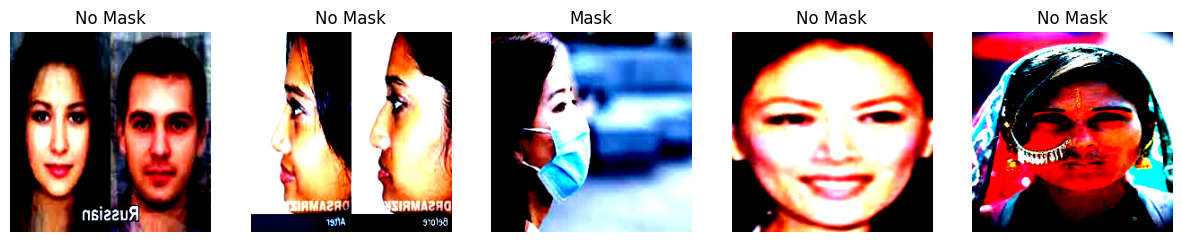

In [33]:
fig, axes = plt.subplots(1, 5, figsize=(15,3))

for i in range(5):
    img, label = train_data[i]
    axes[i].imshow(img.permute(1,2,0))
    axes[i].set_title(class_names[label])
    axes[i].axis("off")

plt.show()

In [34]:
model = models.mobilenet_v2(weights="IMAGENET1K_V1")
model.classifier[1] = nn.Linear(1280, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\admin/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 27.1MB/s]


In [35]:
epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss)

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.4f} | Val Acc: {accuracy:.4f}")


c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10 | Loss: 13.2430 | Val Acc: 0.9940
Epoch 2/10 | Loss: 10.7334 | Val Acc: 0.9894
Epoch 3/10 | Loss: 6.3816 | Val Acc: 0.9974
Epoch 4/10 | Loss: 3.9912 | Val Acc: 0.9874
Epoch 5/10 | Loss: 3.8475 | Val Acc: 0.9974
Epoch 6/10 | Loss: 2.7318 | Val Acc: 0.9907
Epoch 7/10 | Loss: 5.3697 | Val Acc: 0.9901
Epoch 8/10 | Loss: 2.3964 | Val Acc: 0.9940
Epoch 9/10 | Loss: 4.0986 | Val Acc: 0.9854
Epoch 10/10 | Loss: 4.2338 | Val Acc: 0.9921


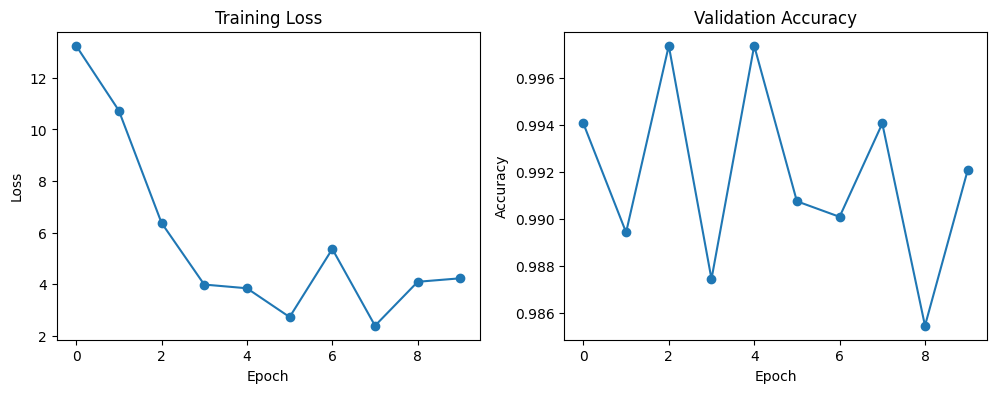

In [36]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(val_accuracies, marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()


In [37]:
torch.save(model.state_dict(), "mask_model.pth")
print("Model saved successfully.")


Model saved successfully.


In [38]:
model = models.mobilenet_v2(weights=None)
model.classifier[1] = nn.Linear(1280, 2)
model.load_state_dict(torch.load("mask_model.pth", map_location=device))
model.eval().to(device)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [39]:
img, label = val_data[0]
img = img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img)
    pred = torch.argmax(output, dim=1).item()

print("Predicted:", class_names[pred])
print("Actual:", class_names[label])


Predicted: Mask
Actual: Mask
